In [244]:
import numpy as np
import pandas as pd
import dataframe_image as dfi
pd.set_option("display.max_rows", None, "display.max_columns", None)
import matplotlib.pyplot as plt
from community import community_louvain
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns

from scipy.spatial.distance import cdist

import json

from os.path import join

import networkx as nx
from networkx.classes.function import set_node_attributes, density
from networkx.algorithms.distance_measures import diameter
from networkx.algorithms.shortest_paths import average_shortest_path_length
from networkx.algorithms.cluster import transitivity
from networkx import attribute_assortativity_coefficient
from networkx.algorithms.centrality import degree_centrality, betweenness_centrality, eigenvector_centrality
from networkx.drawing.nx_pydot import write_dot

In [245]:
ARTIST_PATH = './artist_df.csv'
artist_df = pd.read_csv(ARTIST_PATH)

In [246]:
def make_artist_graph(path, similarity_matrix=None, edge_weight_threshold=0.1):
    artist_df = pd.read_csv(path)
    # aid -> artist id
    # nid -> node id
    aid_nid_map = {}
    def add_aid_nid_mapping(aid_nid_map, aid, nid):
        aid_nid_map[aid] = nid
        return nid
    artist_df['node_id'] = artist_df.apply(lambda row: add_aid_nid_mapping(aid_nid_map, row['artist_id'], row.name), axis = 1)
    nid_aid_map = {nid: aid for (aid, nid) in aid_nid_map.items()}
    nid_list = artist_df['node_id'].tolist()
    artist_graph = nx.Graph()
    artist_graph.add_nodes_from(artist_df['node_id'].tolist())
    edge_attribute_list = []
    if type(similarity_matrix) != type(None):
        for nid in nid_list[:-1]:
            for other_nid in nid_list[nid+1:]:
                edge_weight = similarity_matrix[nid, other_nid]
                if abs(edge_weight) > edge_weight_threshold:
                    weight_dict = {'weight': edge_weight}
                    edge = (nid, other_nid, weight_dict)
                    edge_attribute_list.append(edge)
        artist_graph.add_edges_from(edge_attribute_list)
    else:
        # Add the node attributes to the graph
        node_attrs_dict = {}
        for nid in nid_list:
            row = artist_df.iloc[nid]
            artist_attr_dict = {
                'artist_name': row['artist_name'],
                'total_plays': row['total_plays'],
                'num_listeners': row['num_listeners'],
                'play_ratio': row['play_ratio']
            }
            genres = row['genres'].replace("[", "").replace("]", "").replace("\'", "").split(', ')
            track_freq = json.loads(row['track_freq'].replace("\'", "\""))
            top_listeners = json.loads(row['top_listeners'].replace("\'", "\""))
            artist_attr_dict['genres'], artist_attr_dict['track_freq'], artist_attr_dict['top_listeners'] = \
            genres, track_freq, top_listeners
            node_attrs_dict[nid] = artist_attr_dict
        nx.set_node_attributes(artist_graph, node_attrs_dict)
        # create edge attributes and add them to the graph
        for nid in nid_list[:-1]:
            for other_nid in nid_list[nid+1:]:
                nid_attr_dict, other_nid_attr_dict = artist_graph.nodes[nid], artist_graph.nodes[other_nid]
                total_plays_abs_diff = abs(nid_attr_dict['total_plays'] - other_nid_attr_dict['total_plays'])
                num_listeners_abs_diff = abs(nid_attr_dict['num_listeners'] - other_nid_attr_dict['num_listeners'])
                play_ratio_abs_diff = abs(nid_attr_dict['play_ratio'] - other_nid_attr_dict['play_ratio'])
                listener_overlap = len(set(nid_attr_dict['top_listeners'].keys()).intersection(
                    set(other_nid_attr_dict['top_listeners'].keys())
                )) - 1
                edge_attr_dict = {
                    'total_plays_abs_diff': total_plays_abs_diff,
                    'num_listeners_abs_diff': num_listeners_abs_diff,
                    'play_ratio_diff': play_ratio_abs_diff,
                    'listerner_overlap': listener_overlap
                }
                edge = (nid, other_nid, edge_attr_dict)
                edge_attribute_list.append(edge)
        artist_graph.add_edges_from(edge_attribute_list)
    return artist_graph, aid_nid_map, nid_aid_map

def cluster_count(cluster_label, node_cluster_map):
    count = 0
    for nid, label in node_cluster_map.items():
        if label == cluster_label:
            count += 1
    return count

def calc_majority_labels(df, cluster_node_map, nid_aid_map):
    cluster_majority_label_map = {}
    for cid in cluster_node_map.keys():
        tag_counts = {}
        for nid in cluster_node_map[cid]:
            aid = nid_aid_map[nid]
            tag = df[df['artist_id'] == aid]['tag'].iloc[0]
            if tag in tag_counts:
                tag_counts[tag] += 1
            else:
                tag_counts[tag] = 1
        # calc majority label based on count
        max_label = None
        max_label_count = 0
        for tag, count in tag_counts.items():
            if count >= max_label_count:
                max_label_count = count
                max_label = tag
        
        cluster_majority_label_map[cid] = max_label
        
    return cluster_majority_label_map

def calc_accuracy(actual_tags, predicted_tags):
    N = len(actual_tags)
    num_correct = 0
    for actual, pred in zip(actual_tags, predicted_tags):
        if actual == pred:
            num_correct += 1
    return num_correct/N*100.0

def make_cluster_nodes_mapping(partition_map):
    cluster_nodes_mapping = {cid:[] for cid in set(partition_map.values())}
    for nid, cid in partition_map.items():
        if cid in cluster_nodes_mapping.keys():
            cluster_nodes_mapping[cid].append(nid)
            
    nodes_cluster_mapping = {nid:cid for cid in cluster_nodes_mapping.keys() for nid in cluster_nodes_mapping[cid]}
    
    return cluster_nodes_mapping, nodes_cluster_mapping

def get_large_clusters(cluster_nodes_mapping):
    large_clusters = [cid for cid in cluster_nodes_mapping.keys() if len(cluster_nodes_mapping[cid]) > 1]
    return large_clusters

def list_of_clustered_nodes(cluster_nodes_mapping, large_clusters):
    clustered_nodes = []
    for cid in large_clusters:
        clustered_nodes.extend(cluster_nodes_mapping[cid])
    return clustered_nodes

def predict_labels(cluster_majority_label_map, nodes_cluster_mapping, nodes_list):
    pred_labels = [cluster_majority_label_map[nodes_cluster_mapping[nid]] for nid in nodes_list]
    return pred_labels

def get_actual_labels(artist_df, nid_aid_map, nodes_list):
    actual_labels = [artist_df[artist_df['artist_id'] == nid_aid_map[nid]]['tag'].iloc[0] for nid in nodes_list]
    return actual_labels

def get_graph_degree_dist(graph):
    degrees = [degree for _, degree in graph.degree]
    return degrees

def make_log_degree_dist_plots(degree_data, title, save_fig_path):
    fig, axes = plt.subplots(1, 2, figsize=(16,5))  
    plt.subplot(1, 2, 1)
    plt.hist(degree_data, edgecolor='black', weights=np.zeros_like(degree_data) + 1. / len(degree_data), bins=300)
    plt.xscale('log')
    plt.title(title)
    plt.ylabel(r'Fraction $p_k$ of nodes with degree $k$')
    plt.xlabel(r'Degree $k$ (log scale)')
    plt.subplot(1, 2, 2)
    plt.hist(degree_data, edgecolor='black', weights=np.zeros_like(degree_data) + 1. / len(degree_data), log=True, bins=300)
    plt.xscale('log')
    plt.title(title)
    plt.ylabel(r'Fraction $p_k$ of nodes with degree $k$ (log scale)')
    plt.xlabel(r'Degree $k$ (log scale)')
    fig.savefig(save_fig_path)
    plt.show()

In [247]:
artist_graph, aid_nid_map, nid_aid_map = make_artist_graph(ARTIST_PATH)

artist_features = artist_df[['total_plays', 'num_listeners', 'play_ratio']].values
correlation_matrix = cdist(artist_features, artist_features, 'correlation')

artist_graph_from_corr, _, _ = make_artist_graph(ARTIST_PATH, similarity_matrix=correlation_matrix)

partition = community_louvain.best_partition(artist_graph_from_corr, random_state=0)
dendrogram = community_louvain.generate_dendrogram(artist_graph_from_corr, random_state=0)
modularity = community_louvain.modularity(partition, artist_graph_from_corr)
cluster_nodes_mapping, nodes_cluster_mapping = make_cluster_nodes_mapping(partition)
                                                                         
cluster_majority_label_map = calc_majority_labels(artist_df, cluster_nodes_mapping, nid_aid_map)

edgewidth = [d['weight'] for (u,v,d) in artist_graph_from_corr.edges(data=True)]

large_clusters = get_large_clusters(cluster_nodes_mapping)

clustered_nodes = list_of_clustered_nodes(cluster_nodes_mapping, large_clusters)

In [248]:
modularity

0.10174524523734854

In [249]:
edge_density = density(artist_graph_from_corr)
degree_centrality_map = dict(artist_graph_from_corr.degree(weight='weight'))
betweenness_centrality_map = betweenness_centrality(artist_graph_from_corr)
# eigenvector_centrality_map = eigenvector_centrality(artist_graph_from_corr)

In [250]:
edge_density

0.05874265716785402

In [251]:
artist_id_list = list(aid_nid_map.keys())
artist_names = [artist_df[artist_df['artist_id'] == artist_id]['artist_name'].iloc[0] for artist_id in artist_id_list]
degree_centrality_list = [degree_centrality_map[aid_nid_map[artist_id]] for artist_id in artist_id_list]
betweenness_centrality_list = [betweenness_centrality_map[aid_nid_map[artist_id]] for artist_id in artist_id_list]

In [252]:
degree_centrality_df = pd.DataFrame({'Degree Centrality': degree_centrality_list}, index=artist_names)
degree_centrality_df.sort_values('Degree Centrality', ascending=False, inplace=True)
betweenness_centrality_df = pd.DataFrame({'Betweenness Centrality': betweenness_centrality_list}, index=artist_names)
betweenness_centrality_df.sort_values('Betweenness Centrality', ascending=False, inplace=True)

In [253]:
degree_centrality_df_styled = degree_centrality_df[degree_centrality_df['Degree Centrality'] > 0].style.background_gradient() #adding a gradient based on values in cell
dfi.export(degree_centrality_df_styled, "./degree_centrality.png", max_rows=-1)

In [254]:
betweenness_centrality_df_styled = betweenness_centrality_df[betweenness_centrality_df['Betweenness Centrality'] > 0].style.background_gradient() #adding a gradient based on values in cell
dfi.export(betweenness_centrality_df_styled, "./betweenness_centrality.png", max_rows=-1)

In [255]:
nodes_list = list(nid_aid_map.keys())

In [256]:
predicted_labels = predict_labels(cluster_majority_label_map, nodes_cluster_mapping, nodes_list)
actual_labels = get_actual_labels(artist_df, nid_aid_map, nodes_list)

In [257]:
accuracy_louvain = calc_accuracy(actual_labels, predicted_labels)

In [258]:
accuracy_louvain

44.881889763779526

In [259]:
clustered_nodes_subgraph = artist_graph_from_corr.subgraph(clustered_nodes).copy()
colors = [nodes_cluster_mapping[nid] for nid in clustered_nodes]

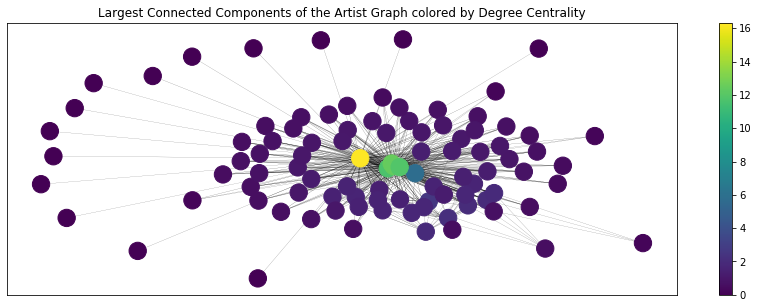

In [260]:
fig, axes = plt.subplots(figsize=(15,5))
norm = mpl.colors.Normalize(vmin=min(degree_centrality_map.values()), vmax=max(degree_centrality_map.values())+1)
cmap = cm.viridis
pos = nx.spring_layout(clustered_nodes_subgraph)
# color the nodes according to their partition
# nx.draw(clustered_nodes_subgraph)
nx.draw_networkx_edges(clustered_nodes_subgraph, pos, width=edgewidth)
nx.draw_networkx_nodes(clustered_nodes_subgraph, pos, nodelist=clustered_nodes,
                       node_color=[degree_centrality_map[nid] for nid in clustered_nodes], 
                       cmap=cmap, label=clustered_nodes)
plt.title('Largest Connected Components of the Artist Graph colored by Degree Centrality')
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
plt.show()

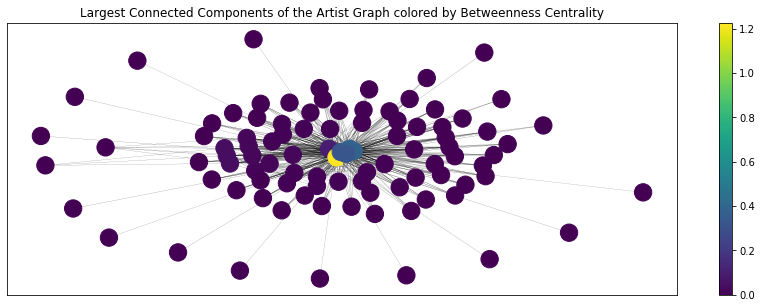

In [261]:
fig, axes = plt.subplots(figsize=(15,5))
pos = nx.spring_layout(clustered_nodes_subgraph)
# color the nodes according to their partition
# nx.draw_networkx(clustered_nodes_subgraph, pos)
norm = mpl.colors.Normalize(vmin=min(betweenness_centrality_map.values()), vmax=max(betweenness_centrality_map.values())+1)
cmap = cm.viridis
nx.draw_networkx_edges(clustered_nodes_subgraph, pos, width=edgewidth)
nx.draw_networkx_nodes(clustered_nodes_subgraph, pos, nodelist=clustered_nodes,
                       node_color=[betweenness_centrality_map[nid] for nid in clustered_nodes])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
plt.title('Largest Connected Components of the Artist Graph colored by Betweenness Centrality')
plt.show()

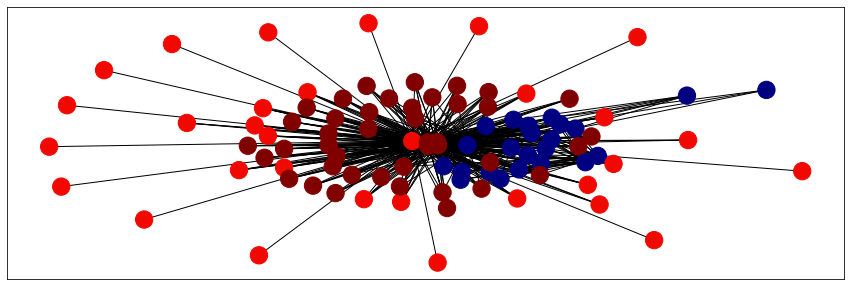

In [262]:
fig, axes = plt.subplots(figsize=(15,5))
pos = nx.spring_layout(clustered_nodes_subgraph)
# color the nodes according to their partition
# nx.draw(clustered_nodes_subgraph)
nx.draw_networkx_edges(clustered_nodes_subgraph, pos)
nx.draw_networkx_nodes(clustered_nodes_subgraph, pos, nodelist=clustered_nodes,
                       node_color=colors, cmap=plt.cm.jet, label=clustered_nodes)
plt.show()

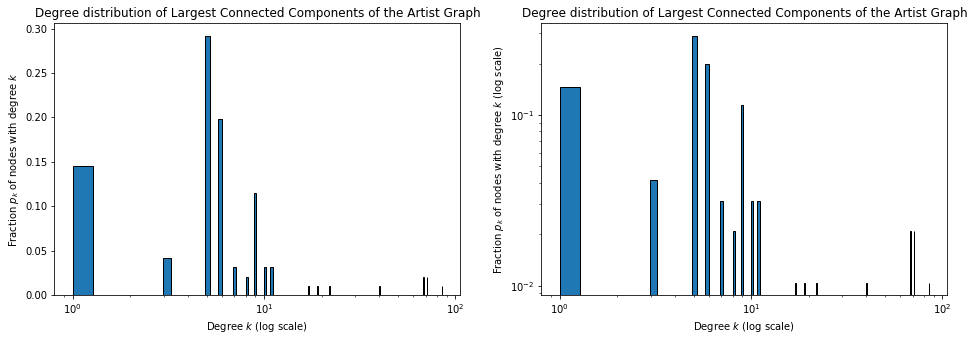

In [263]:
subcluster_degrees = get_graph_degree_dist(clustered_nodes_subgraph)
make_log_degree_dist_plots(subcluster_degrees, 'Degree distribution of Largest Connected Components of the Artist Graph', 'degree_dist_artist_graph.png')

In [264]:
induced_graph = community_louvain.induced_graph(partition, artist_graph_from_corr)

In [265]:
cluster_graph = induced_graph.subgraph(large_clusters).copy()

In [266]:
cluster_weights

{(1, 1): 9.393262265684331,
 (1, 11): 17.907260622125737,
 (1, 10): 4.1787721204586985,
 (10, 10): 3.925923853084144,
 (10, 11): 14.34633366229562,
 (11, 11): 24.178033872638817}

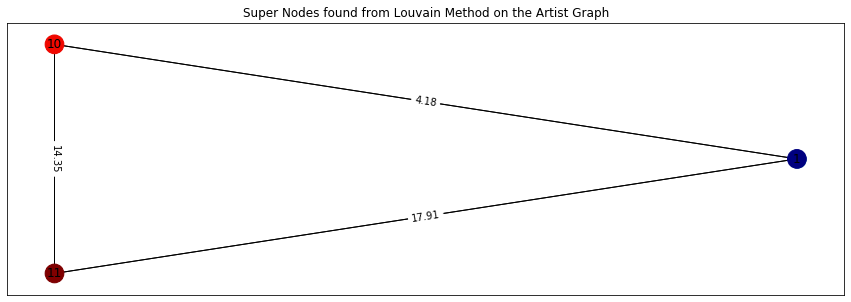

In [267]:
# draw the graph
fig, axes = plt.subplots(figsize=(15,5))
pos = nx.circular_layout(cluster_graph)
# color the nodes according to their partition
cluster_weights = nx.get_edge_attributes(cluster_graph, 'weight')
cluster_weights_no_self_loops = {}
for edge in cluster_weights.keys():
    if edge[0] == edge[1]:
        continue
    cluster_weights_no_self_loops[edge] = round(cluster_weights[edge], 2)
nx.draw_networkx(cluster_graph, pos)
nx.draw_networkx_nodes(cluster_graph, pos, nodelist=large_clusters, node_size=350,
                       cmap=plt.cm.jet, node_color=large_clusters)
nx.draw_networkx_edges(cluster_graph, pos)
nx.draw_networkx_edge_labels(cluster_graph, pos, edge_labels=cluster_weights_no_self_loops)
plt.title('Super Nodes found from Louvain Method on the Artist Graph')
fig.savefig('super_nodes_artist_graph.png')
plt.show()


In [268]:
cluster_weights

{(1, 1): 9.393262265684331,
 (1, 11): 17.907260622125737,
 (1, 10): 4.1787721204586985,
 (10, 10): 3.925923853084144,
 (10, 11): 14.34633366229562,
 (11, 11): 24.178033872638817}